# Introduction

[insert intro here]

# Methods and Results

### Reading and Loading Data

In [27]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)


After loading the packages, we read the data and clean as necessary. We remove the date columns, as these are not relevant to our classification, and mutatue the Classes column to be a factor so it can be used as the classifier. A parsing failure occurrs because of the format of the original dataset, which puts region titles in rows 123 and 168, throwing off the rest of the data. As we only use rows 1-122 (the Bejaia region data), this failure can be ignored.


In [28]:
fire_data_read <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                      skip = 1)

#selecting only the Bejaia region data, as dataset also includes the Sidi Bel Abbes region
fire_data_full <- slice(fire_data_read, 1:122) %>%
    mutate(Classes = as_factor(Classes)) %>% 
    select(-day, -month, -year) %>% 
    mutate(across(Temperature:FWI, as.double))
fire_data_full

#parsing failures are because of region titles in rows 123 and 168 - we only used rows 1-122, so failures are irrelevant

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,not fire
26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire
25,78,14,1.4,45.0,1.9,7.5,0.2,2.4,0.1,not fire


*Table 1: Loaded dataset with irrelevant columns*

In [29]:
fire_data <- fire_data_full %>% 
    select(Temperature, Ws, FWI, Classes)
fire_data

Temperature,Ws,FWI,Classes
<dbl>,<dbl>,<dbl>,<fct>
29,18,0.5,not fire
29,13,0.4,not fire
26,22,0.1,not fire
⋮,⋮,⋮,⋮
32,14,0.9,not fire
26,16,0.1,not fire
25,14,0.1,not fire


*Table 2: Cleaned dataset, ready to be used in classification*

### Preliminary Data Analysis

In [58]:
set.seed(1)


fire_split <- initial_split(fire_data, prop = 0.7, strata = Classes)
fire_training <- training(fire_split)
fire_testing <- testing(fire_split)


class_counts <- fire_training %>%
    group_by(Classes) %>%
    summarize(count = n()) %>% 
    mutate(fraction = count/nrow(fire_training))
class_counts

`summarise()` ungrouping output (override with `.groups` argument)



Classes,count,fraction
<fct>,<int>,<dbl>
not fire,45,0.5172414
fire,42,0.4827586


*Table 3: Fraction of each class in the training dataset*

In [31]:
predictor_means <- fire_training %>%
    select(Temperature:FWI) %>%
    map_df(mean) %>%
    pivot_longer(cols = Temperature:FWI,
                names_to = "Predictor",
                values_to = "Mean")
predictor_means

Predictor,Mean
<chr>,<dbl>
Temperature,31.149425
Ws,15.942529
FWI,5.733333


*Table 4: Mean value of each predictor*

The following visualization shows the prevalence of each temperature observation and whether the observation is labelled "fire" or "not fire". Under 30° C, very few fires are observed, and above 35° C, nearly every observation is of fire.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


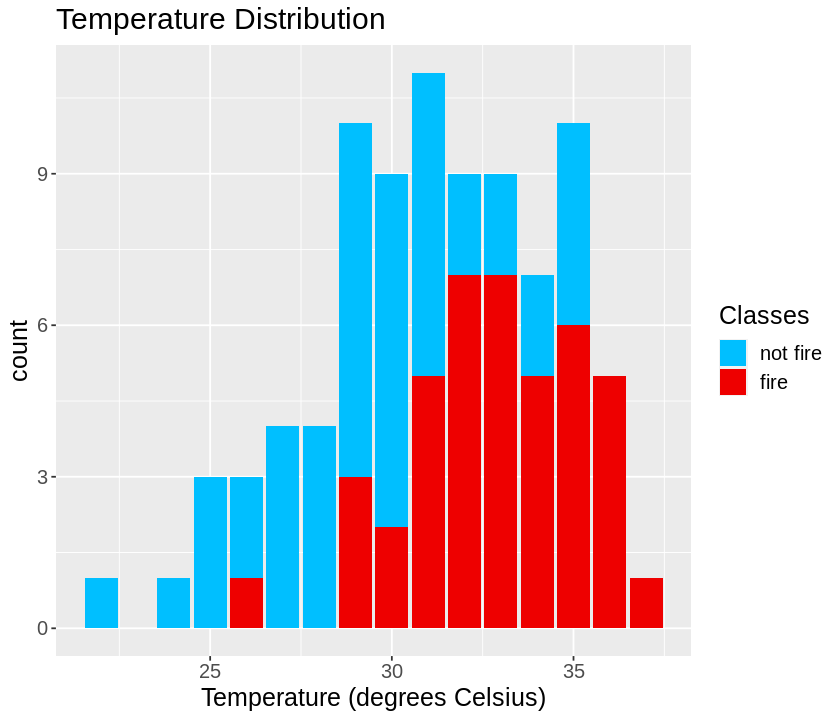

In [59]:
options(repr.plot.width = 7, repr.plot.height = 6)

temp_dstn_plot <- fire_training %>%
    ggplot(aes(x = Temperature, fill = Classes)) + 
    geom_histogram(stat = "count", binwidth = 1) +
    labs(x = "Temperature (degrees Celsius)") + 
    ggtitle("Temperature Distribution") +
    scale_fill_manual(values = c("deepskyblue1", "red2")) +
    theme(text = element_text(size = 15))
temp_dstn_plot

*Figure 1: Distribution of temperature values coloured by class*

This visualization is of the distribution of windspeed observations and whether they are labelled "fire" or "not fire". The windspeed does not seem to correlate strongly to either class, though very few observations of fire are seen above 19 km/h.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


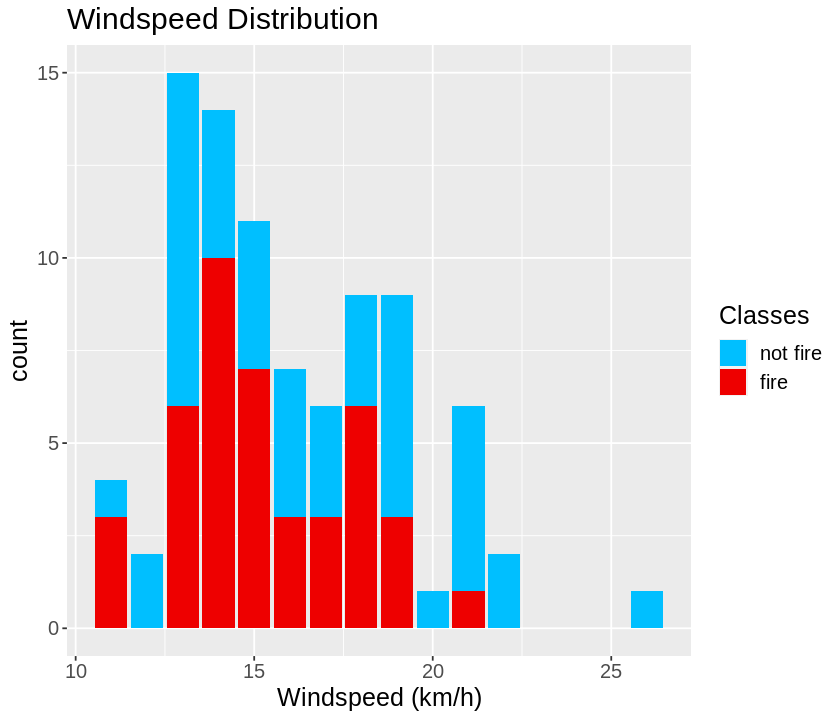

In [60]:
ws_dstn_plot <- fire_training %>%
    ggplot(aes(x = Ws, fill = Classes)) + 
    geom_histogram(stat = "count") +
    labs(x = "Windspeed (km/h)") + 
    ggtitle("Windspeed Distribution") +
    scale_fill_manual(values = c("deepskyblue1", "red2")) +
    theme(text = element_text(size = 15))
ws_dstn_plot

*Figure 2: Distribution of windspeed values coloured by class*

This visualization shows the distribution of Fire Weather Index observations and their corresponding label of "fire" or "not fire". As seen here, FWI values of over 4 are highly correlated with an observation of fire. There are no days with an FWI value of 6 or above where fire is *not* observed.

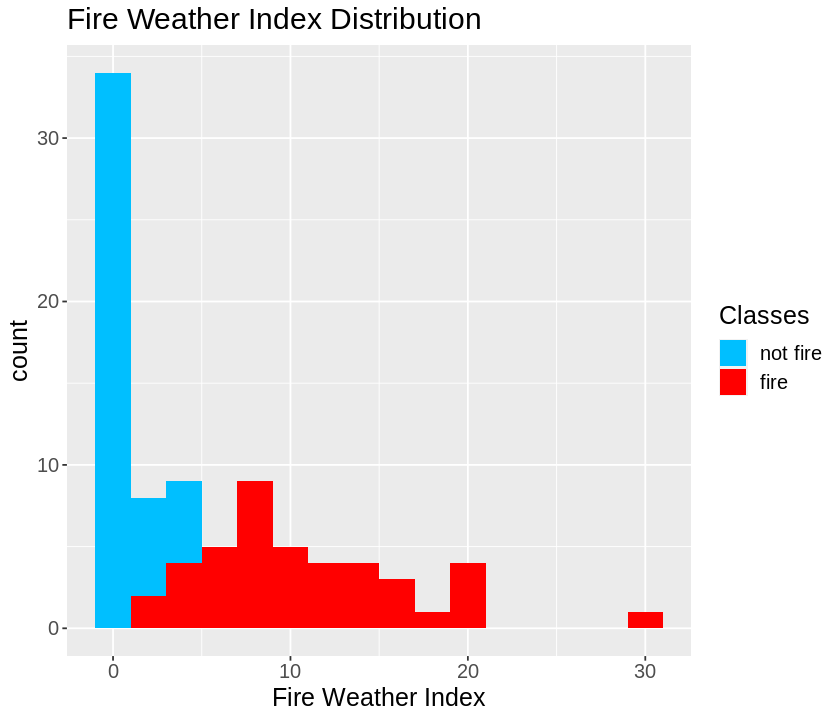

In [61]:
FWI_dstn_plot <- fire_training %>%
    ggplot(aes(x = FWI, fill = Classes)) + 
    geom_histogram(binwidth = 2) +
    labs(x = "Fire Weather Index") + 
    ggtitle("Fire Weather Index Distribution") +
    theme(text = element_text(size = 15)) +
    scale_fill_manual(values = c("deepskyblue1", "red1"))

FWI_dstn_plot

*Figure 3: Distribution of FWI values coloured by class*

This visualization plots windspeed versus temperature and labels each observation according to its class as "fire" or "not fire". Windspeeds of 15–20 km/hr together with temperatures above 33° C are most likely to be on fire.

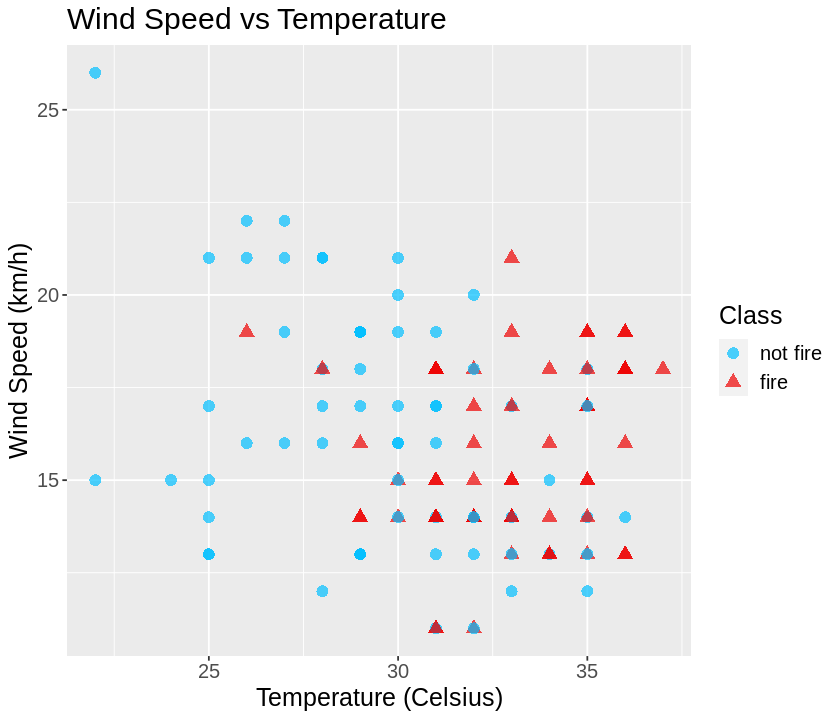

In [62]:
temp_ws_plot <- ggplot(fire_data, aes(x = Temperature, y = Ws)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "Wind Speed (km/h)", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2")) +
    ggtitle("Wind Speed vs Temperature")

temp_ws_plot

*Figure 4: Plot of windspeed vs temperature values*

This visualization plots Fire Weather Index versus temperature. FWI values of 5 and above together with temperatures of above 30° C are most likely to be on fire, with strong correlation between the variables and little overlap between the "fire" and "not fire" groups.

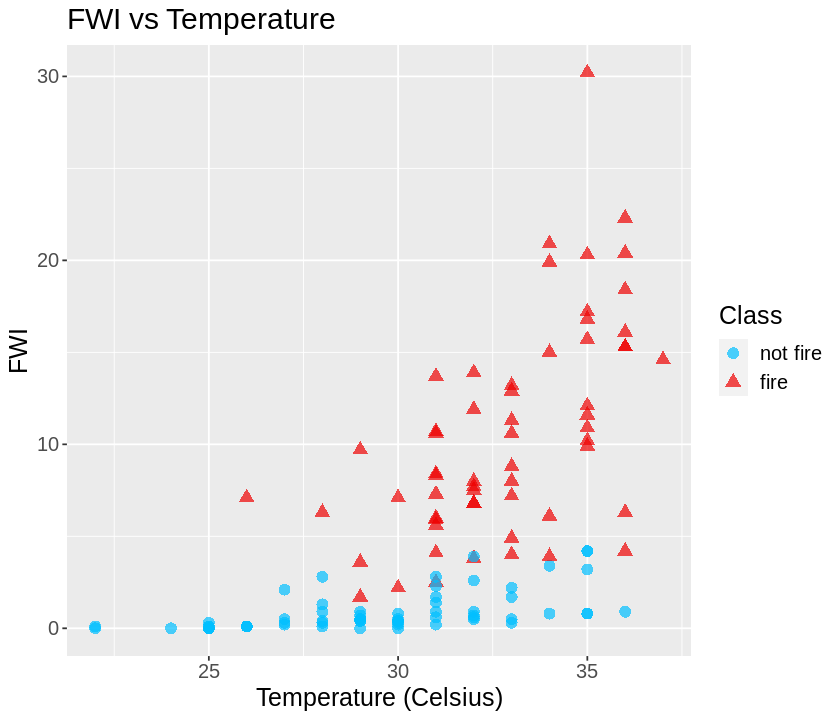

In [63]:
temp_FWI_plot <- ggplot(fire_data, aes(x = Temperature, y = FWI)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2")) +
    ggtitle("FWI vs Temperature")
    
temp_FWI_plot

*Figure 5: Plot of FWI vs temperature values*

This visualization plots Fire Weather Index versus wind speed. There is not strong correlation between the variables, but there is also not much overlap between the "fire" and "not fire" classes. Fire is most likely to occur when FWI values are above 5 and wind speeds are below 18 km/h. 

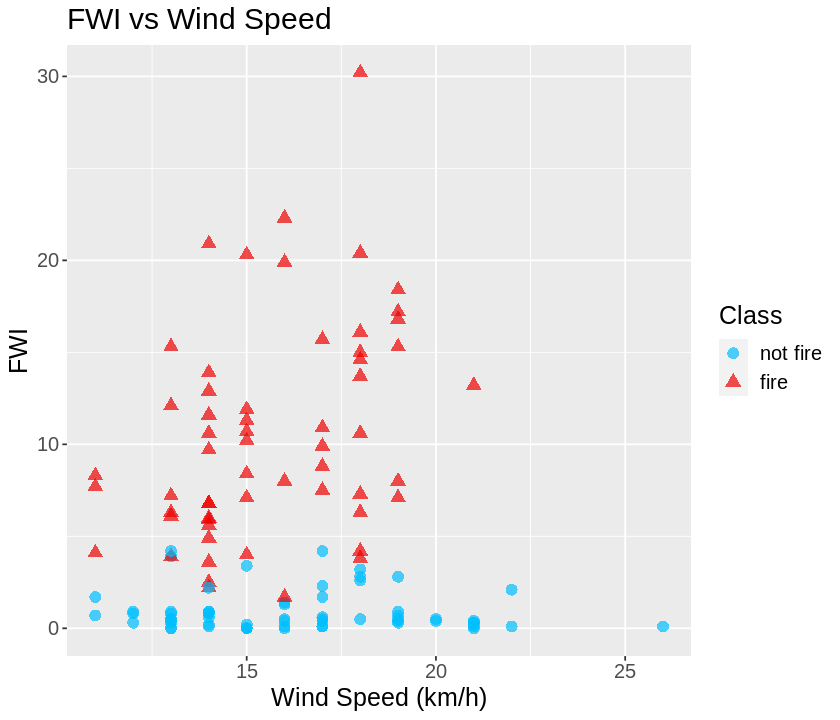

In [64]:
WS_FWI_plot <- ggplot(fire_data, aes(x = Ws, y = FWI)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Wind Speed (km/h)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2")) +
    ggtitle("FWI vs Wind Speed")
    
WS_FWI_plot

*Figure 6: Plot of FWI vs windspeed values*

### Classification Methods

In [39]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

In [40]:
set.seed(1)

fire_crossval <- vfold_cv(fire_training, v = 5, strata = Classes)

In [41]:
fire_recipe <- recipe(Classes ~ FWI + Temperature + Ws, data = fire_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

In [42]:
fire_resample <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = fire_crossval)

In [43]:
fire_crossval_metrics <- collect_metrics(fire_resample) %>% 
    filter(.metric == "accuracy") %>% 
    arrange(desc(mean))
fire_crossval_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.9300654,5,0.02210658,Model02
4,accuracy,binary,0.9300654,5,0.02210658,Model03
2,accuracy,binary,0.9078431,5,0.01433445,Model01
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.8967320,5,0.01120682,Model09
15,accuracy,binary,0.8738562,5,0.02121919,Model10
12,accuracy,binary,0.8732026,5,0.02912716,Model08


*Table 5: Estimated accuracy of each k-value*

In [44]:
fire_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = 3) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

In [45]:
fire_fit <- workflow() %>% 
    add_recipe(fire_recipe) %>% 
    add_model(fire_spec) %>% 
    fit(data = fire_training)

In [46]:
fire_predictions <- predict(fire_fit, fire_testing) %>% 
    bind_cols(fire_testing)

### Classification Results

In [47]:
fire_metrics <- fire_predictions %>% 
    metrics(truth = Classes, estimate = .pred_class) %>% 
    filter(.metric == "accuracy")
fire_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9142857


*Table 6: Accuracy of final classification model*

In [48]:
fire_conf_mat <- fire_predictions %>% 
    conf_mat(truth = Classes, estimate = .pred_class)
fire_conf_mat

          Truth
Prediction not fire fire
  not fire       18    3
  fire            0   14

*Table 7: Confusion matrix for the final classification model*

Should note: In this case, a false negative is worse than a false positive, so it's a little problematic that the model erred on the side of "not fire" rather than on the side of "fire". However, with an accuracy of 90%, the model is by far accurate enough to be useful on a day-to-day basis.

In [49]:
fire_wrong_prediction_labeled <- fire_predictions %>% 
    filter(.pred_class != Classes)
fire_prediction_intermediate <- fire_predictions %>% 
    filter(.pred_class == Classes)
df0 <- subset(fire_wrong_prediction_labeled, select = -c(Classes))

df = subset(fire_wrong_prediction_labeled, select = -c(.pred_class,Temperature, Ws, FWI) )
df_new = cbind(df0, c("fire predicted as not fire")) %>% 
    rename()
colnames(df_new) <- c(".pred_class", "Temperature", "Ws", "FWI", "Classes")
df_new <- df_new %>% 
    mutate(Classes = as.factor(Classes))
fire_new <- rbind(fire_prediction_intermediate, df_new)

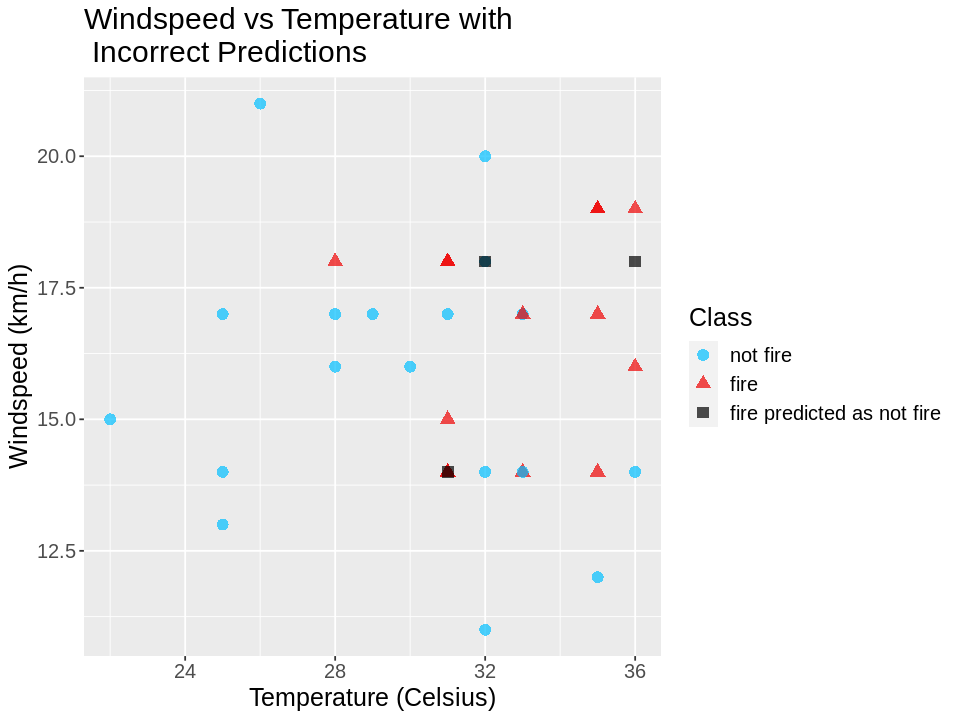

In [74]:
options(repr.plot.height = 6, repr.plot.width = 8)

t_vs_ws_results <- fire_new %>% 
    ggplot(aes(x = Temperature, y = Ws, color = Classes, shape = Classes)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "Windspeed (km/h)", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2", "black")) +
    ggtitle("Windspeed vs Temperature with \n Incorrect Predictions")
    
t_vs_ws_results 

*Figure 7: Plot of windspeed vs temperature with 
incorrect predictions plotted as black squares*

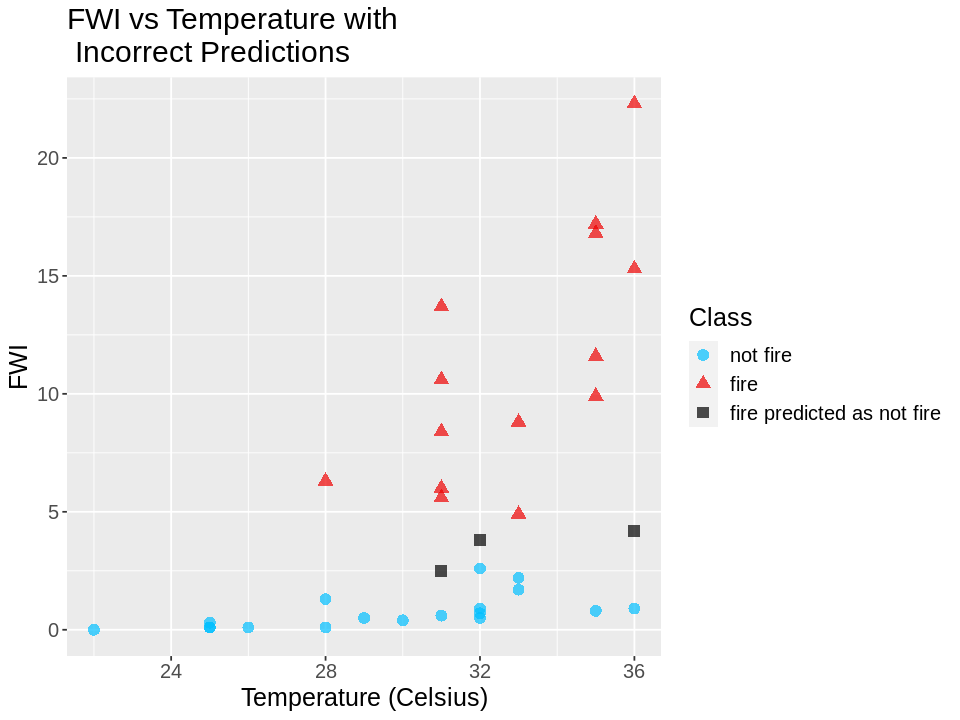

In [75]:
options(repr.plot.height = 6, repr.plot.width = 8)

t_vs_fwi_results <- fire_new %>% 
    ggplot(aes(x = Temperature, y = FWI, color = Classes, shape = Classes)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Temperature (Celsius)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2", "black")) +
    ggtitle("FWI vs Temperature with \n Incorrect Predictions")
    
t_vs_fwi_results 

*Figure 8: Plot of FWI vs temperature with incorrect predictions plotted as black squares*

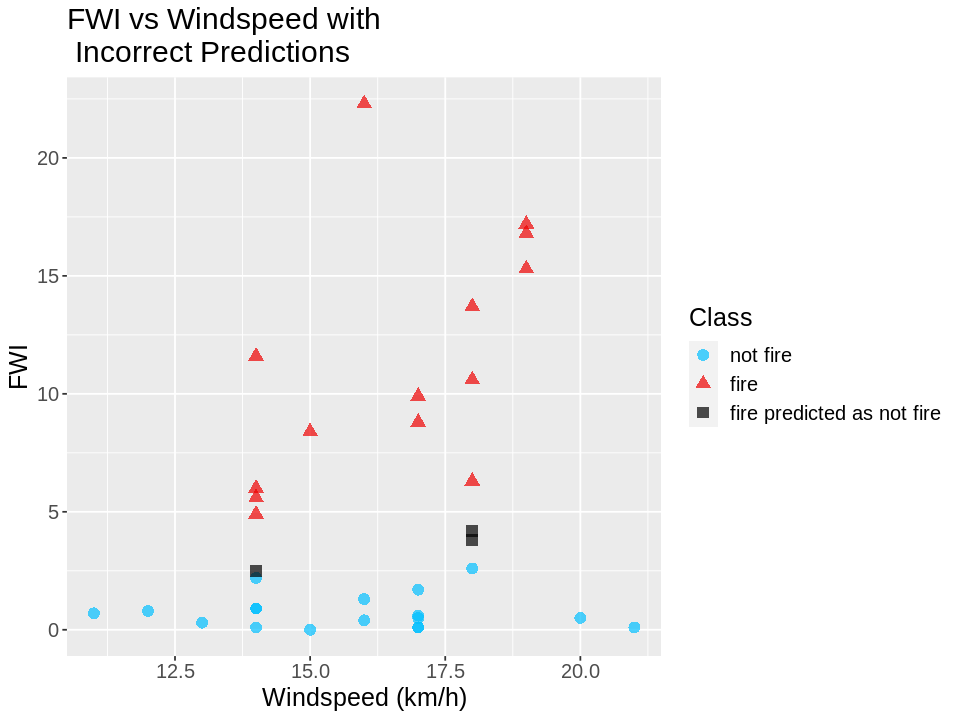

In [76]:
options(repr.plot.height = 6, repr.plot.width = 8)

t_vs_ws_results <- fire_new %>% 
    ggplot(aes(x = Ws, y = FWI, color = Classes, shape = Classes)) +
    geom_point(aes(color = Classes, shape = Classes), size = 3, alpha = 0.7) +
    labs(x = "Windspeed (km/h)", y = "FWI", color = "Class", shape = "Class") +
    theme(text = element_text(size = 15)) +
    scale_color_manual(values = c("deepskyblue1", "red2", "black")) +
    ggtitle("FWI vs Windspeed with \n Incorrect Predictions")
    
t_vs_ws_results

*Figure 9: Plot of FWI vs windspeed with incorrect predictions plotted as black squares*

# Discussion